In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from demographicmodel import DemographicModel
import helpers as h

In [3]:
def readsim(fn):
    times = None
    sizes = None
    with open(fn) as infile:
        while True:
            line = infile.readline()
            if not line.startswith("#"):
                break
            elif line.startswith("#DEMOCHANGE_TIMES"):
                times = np.array(line.split("=")[1].split(','), dtype=float)
            elif line.startswith("#DEMOCHANGE_SIZES"):
                sizes = np.array(line.split("=")[1].split(','), dtype=float)

        sfs = np.array(line.split(), dtype=float)
        twosfs = np.zeros((len(sfs), len(sfs)))
        twosfs[np.triu_indices_from(twosfs)] = np.array(infile.readline().split(), dtype=float)
        
    twosfs[np.diag_indices_from(twosfs)] /= 2
    twosfs += np.transpose(twosfs)
    
    return sfs, twosfs, times, sizes

In [4]:
def lump_sfs(sfs, bmax):
    sfs_lumped = np.zeros(bmax+1)
    sfs_lumped[:bmax] = sfs[:bmax]
    sfs_lumped[bmax] = sum(sfs[bmax:])
    return(sfs_lumped)

def normalize_sfs(sfs):
    return sfs / np.sum(sfs)

def lump_2sfs(twosfs, bmax):
    lumped = np.zeros((bmax+1, bmax+1))
    lumped[:bmax,:bmax] = twosfs[:bmax,:bmax]
    lumped[bmax,:bmax] = np.sum(twosfs[bmax:,:bmax],axis=0)
    lumped[:bmax, bmax] = np.sum(twosfs[:bmax:, bmax:],axis=1)
    lumped[bmax, bmax] = np.sum(twosfs[bmax:,bmax:])
    return(lumped)

# def kldiv(p, q):
#     return - np.sum(p*np.log2(q/p))


In [5]:
ALPHAS = [1.975, 1.95, 1.9, 1.85, 1.8, 1.75, 1.625, 1.5]
RS = [0.0, 0.5, 1.0, 2.5, 5.0]
# RS = [1.0]

n = 100
model = "ConstFixedTimes"
maxb = 10

In [6]:
sfs_fitted = {}
twosfs_fitted = {} 
# pattern_fitted = "../simulations/msprime/jsfs_fastNeutrino-xibeta_n-{}_alpha-{}_{}_r-{}.scaled.txt"

sfs_xibeta = {}
twosfs_xibeta = {}
# pattern_xibeta = "../simulations/msprime/jsfs_n-{}_xibeta-{}_r-{}.scaled.txt"

for alpha in ALPHAS:
    for r in RS:
        if r == 0:
            pattern_fitted = "../simulations/msprime/jsfs_fastNeutrino-xibeta_n-{}_alpha-{}_{}_r-{}.txt"
            pattern_xibeta = "../simulations/msprime/jsfs_n-{}_xibeta-{}_r-{}.txt"
        else:
            pattern_fitted = "../simulations/msprime/jsfs_fastNeutrino-xibeta_n-{}_alpha-{}_{}_r-{}.scaled.txt"
            pattern_xibeta = "../simulations/msprime/jsfs_n-{}_xibeta-{}_r-{}.scaled.txt"


        # Get fitted simulations
        fn = pattern_fitted.format(n, alpha, model, r)
        try:
            sfs, twosfs, _, _ = readsim(fn)
            sfs_fitted[(alpha,r)] = sfs
            twosfs_fitted[(alpha,r)] = twosfs
        except:
            print("Fitted Alpha={}, r={} not found".format(alpha, r))
        
        # Get XiBeta simulations
        fn = pattern_xibeta.format(n, alpha, r)
        try:
            sfs, twosfs, _, _ = readsim(fn)
            sfs_xibeta[(alpha,r)] = sfs
            twosfs_xibeta[(alpha,r)] = twosfs
        except:
            print("XiBeta alpha={}, r={} not found".format(alpha, r))
            

## Site Frequency Spectrum plots

In [7]:
r = 0.0

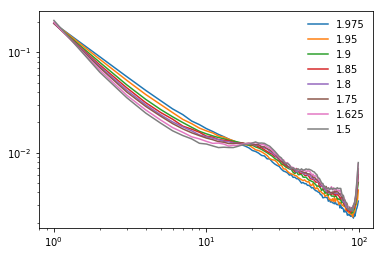

In [8]:
daf = np.arange(1,n)

for alpha in ALPHAS:
    plt.loglog(daf, sfs_xibeta[(alpha,r)] / np.sum(sfs_xibeta[(alpha,r)]), label=alpha)
plt.legend()

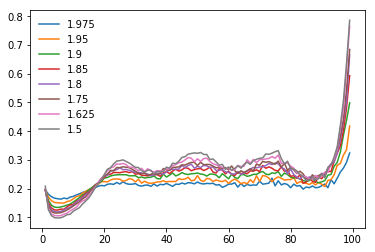

In [9]:
daf = np.arange(1,n)
for alpha in ALPHAS:
    plt.plot(daf, sfs_xibeta[(alpha,r)] / np.sum(sfs_xibeta[(alpha,r)]) * daf, label=alpha)
plt.legend()

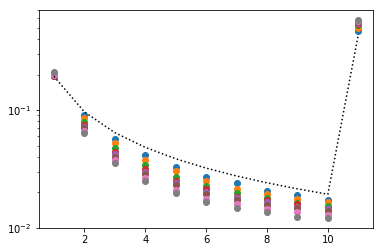

In [10]:
x = np.arange(1,12)

for alpha in ALPHAS:
    plt.semilogy(x, lump_sfs(sfs_xibeta[(alpha,r)]/np.sum(sfs_xibeta[(alpha,r)]), maxb), 'o')
plt.semilogy(x, lump_sfs(1/np.arange(1,n), maxb)/np.sum(1/np.arange(1,n)), ':k')


## Fitted demographic models

In [11]:
def plot_model(ax, model, scale=None, **kwargs):
    t = np.append(model.times, model.times[-1]*2)
    y = np.append(model.sizes, model.sizes[-1])
    if scale is not None:
        t /= scale
        y /= scale
    ax.plot(t, y, drawstyle="steps-post", **kwargs)
    return ax

In [12]:
model_dict = {}
for alpha in ALPHAS:
    fn = "../fastNeutrino/fitted_params/n-{}_xibeta-{}.{}.txt".format(n,alpha,model)
    dm = DemographicModel(fn)
    dm.rescale()
    model_dict[alpha] = dm

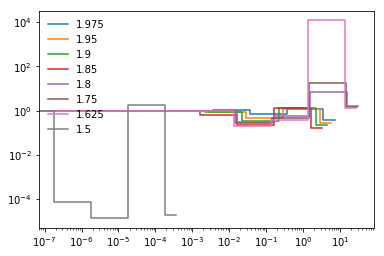

In [13]:
ax = plt.subplot(111)
for alpha in ALPHAS:
    plot_model(ax, model_dict[alpha], label=alpha)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
# ax.set_ylim([0.08, (5/4)*100])

(0.08, 125.0)

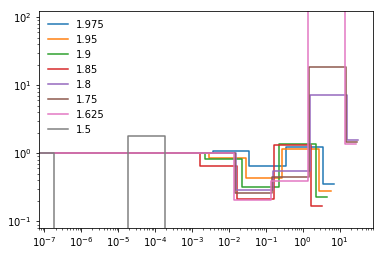

In [14]:
ax = plt.subplot(111)
for alpha in ALPHAS:
    plot_model(ax, model_dict[alpha], label=alpha)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_ylim([0.08, (5/4)*100])

## Compare fitted to Xi-Beta SFS

1.975


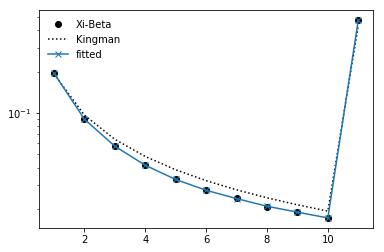

1.95


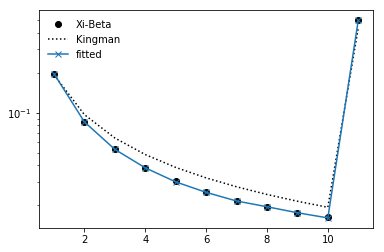

1.9


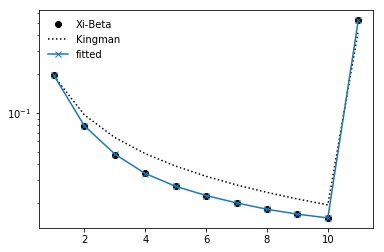

1.85


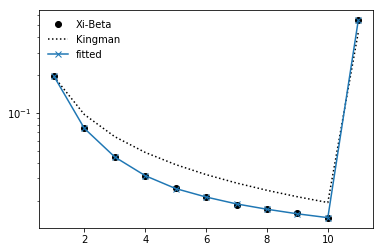

1.8


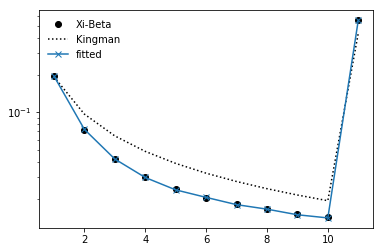

1.75


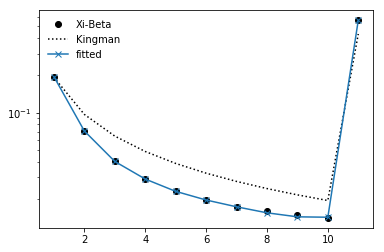

1.625


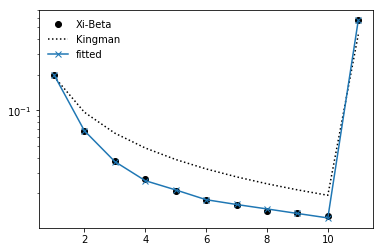

1.5


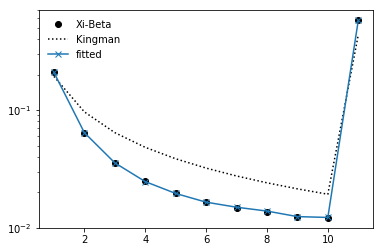

In [15]:
x = np.arange(1, maxb+2)

for alpha in ALPHAS:
    print(alpha)
    fig = plt.figure()
    
    sfs = normalize_sfs(sfs_xibeta[(alpha,r)])
    plt.plot(x, lump_sfs(sfs, 10), 'ok', label="Xi-Beta")
    plt.plot(x, lump_sfs(1/np.arange(1,n), maxb)/np.sum(1/np.arange(1,n)), ':k', label='Kingman')

    try:
        sfs = normalize_sfs(sfs_fitted[(alpha,r)])
    except KeyError:
        print("not found")
        plt.show()
        continue
    plt.semilogy(x, lump_sfs(sfs,10), '-x', label="fitted")#, label=model)

    plt.legend()
    plt.show()



1.975


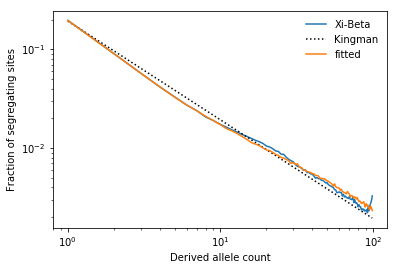

1.95


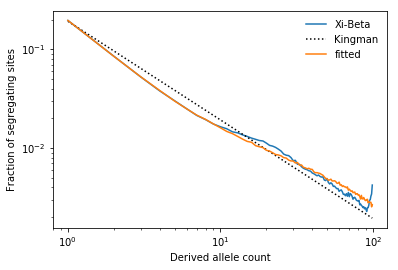

1.9


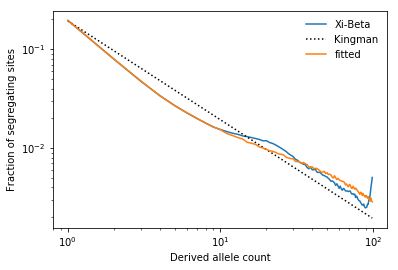

1.85


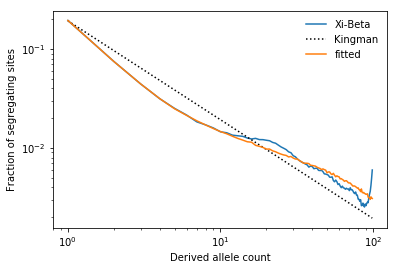

1.8


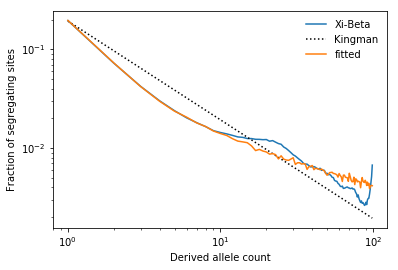

1.75


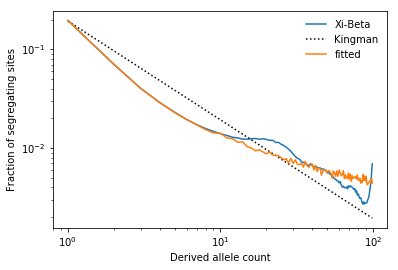

1.625


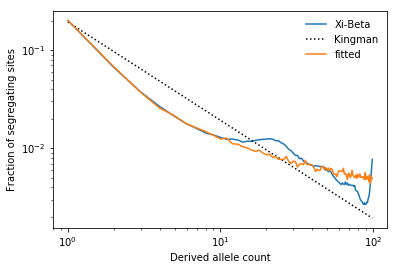

1.5


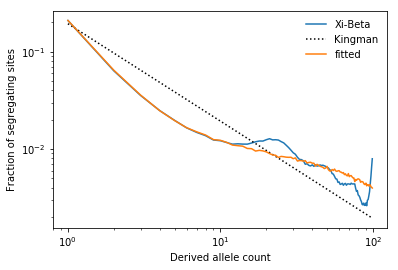

In [16]:
x = np.arange(1,n)

for alpha in ALPHAS:
    print(alpha)
    fig = plt.figure()
    
    sfs = normalize_sfs(sfs_xibeta[(alpha,r)])
    plt.loglog(x, sfs, label="Xi-Beta")
    plt.loglog(x, (1/x)/np.sum(1/x), ':k', label='Kingman')

    try:
        sfs = normalize_sfs(sfs_fitted[(alpha,r)])
    except KeyError:
        print("not found")
        plt.show()
        continue
    plt.loglog(x, sfs, '-', label="fitted")#, label=model)

    plt.legend()
    plt.ylabel("Fraction of segregating sites")
    plt.xlabel("Derived allele count")
    plt.show()



'1.975':1.9147040163086877,
('1.975','ConstFixedTimes'):0.9857570954110398,
'1.95':1.8580860017797316,
('1.95','ConstFixedTimes'):0.8060548337628121,
'1.9':1.7936099273119825,
('1.9','ConstFixedTimes'):0.7484995401521894,
'1.85':1.7596684029993237,
('1.85','ConstFixedTimes'):0.5916311947466382,
'1.8':1.7228157901104733,
('1.8','ConstFixedTimes'):0.7326115473889974,
'1.75':1.700555522433559,
('1.75','ConstFixedTimes'):0.7036971458515244,
'1.625':1.6624201582014804,
('1.625','ConstFixedTimes'):0.6410797980679432,
'1.5':1.6373134579807764,
('1.5','ConstFixedTimes'):6.279944311189792e-05,


Text(0.5, 0, 'Alpha')

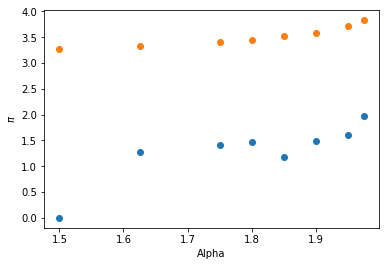

In [17]:
pi_xibeta={}
pi_fitted={}

for alpha in ALPHAS:
    sfs = sfs_xibeta[(alpha,r)]
    sfs = (sfs + sfs[::-1])[:n//2]
    pi_xibeta[alpha] = h.sfs2pi(sfs,n)

    sfs = sfs_fitted[(alpha,r)]
    sfs = (sfs + sfs[::-1])[:n//2]
    pi_fitted[alpha] = h.sfs2pi(sfs,n)

    plt.plot(alpha, pi_fitted[alpha], 'o', c='C0')
    plt.plot(alpha, pi_xibeta[alpha], 'o', c='C1')
    
    print("'{}':{},".format(alpha,pi_xibeta[alpha]/2))
    print("('{}','{}'):{},".format(alpha,model,pi_fitted[alpha]/2))
    

plt.ylabel("$\pi$")
plt.xlabel("Alpha")
# plt.ylim([-0.0195,0.0195])
#     plt.plot(alpha, pi_fitted, 'ob')

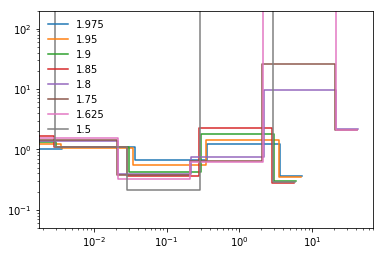

In [18]:
ax = plt.subplot(111)
for alpha in ALPHAS:
    plot_model(ax, model_dict[alpha], label=alpha, scale=pi_fitted[alpha]/2)# , color=str(1-alpha))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([0.05,200])
ax.legend()

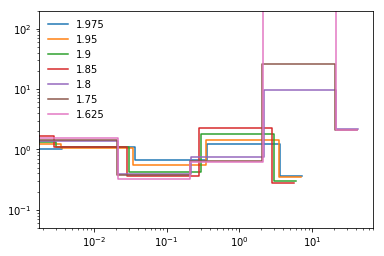

In [19]:
ax = plt.subplot(111)
for alpha in ALPHAS[:-1]:
    plot_model(ax, model_dict[alpha], label=alpha, scale=pi_fitted[alpha]/2)# , color=str(1-alpha))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([0.05,200])
ax.legend()

## 2-SFS

In [20]:
def conditional_sfs(twosfs):
    F = np.cumsum(twosfs, axis=1)
    F /= F[:,-1][:,None]
    return F

In [21]:
def fold_twosfs(twosfs):
    n_samples = twosfs.shape[0] + 1
    folded = (twosfs + twosfs[::-1,:] + twosfs[:,::-1] + twosfs[::-1,::-1])[:n_samples//2, :n_samples//2]
    if n_samples % 2 == 0:
        folded[:,-1] /= 2
        folded[-1,:] /= 2
    return folded

In [22]:
def distance(F1, F2):
    return np.max(np.abs(F1 - F2), axis=1)

In [23]:
def resample_distance(sampling_dist, comparison_dist, n_obs, n_reps):
    F_exp = conditional_sfs(comparison_dist)
    
    D = np.zeros((n_reps, sampling_dist.shape[0]))
    for rep in range(n_reps):
        rand_counts = np.random.multinomial(n_obs, sampling_dist.ravel()).reshape(sampling_dist.shape)
        rand_counts = (rand_counts + rand_counts.T) / 2
        
        cumcounts = np.cumsum(rand_counts, axis=1)
        n_row = cumcounts[:,-1]
        F_obs = cumcounts / n_row[:,None]
        
        D[rep] = distance(F_exp, F_obs) * np.sqrt(n_row)

    return D

In [24]:
def rank(value, comparisons):
    return np.sum(value[:,None] > comparisons[None,:], axis=0)

In [25]:
def violin_with_iqrange(ax, data, color):
    x = np.arange(1, data.shape[1]+1)
    lb = np.percentile(data, 25, axis=0)
    ub = np.percentile(data, 75, axis=0)
    ax.violinplot(data, showextrema=False)
    ax.plot(x, lb, linestyle='', marker='_', color=color)
    ax.plot(x, ub, linestyle='', marker='_', color=color)
    ax.vlines(x, ub, lb, color=color)
    return ax

In [26]:
NPAIRS = [1000, 5000, 10000]

In [27]:
n_resample = 1000
D_kingman = {}
D_xibeta = {}

for alpha in ALPHAS:
    print(alpha)
    for r in RS:
        try:
            f_xibeta = normalize_sfs(fold_twosfs(twosfs_xibeta[(alpha,r)]))
            f_fitted = normalize_sfs(fold_twosfs(twosfs_fitted[(alpha,r)]))
        except KeyError:
            continue

        if f_xibeta.size == 0 or f_fitted.size == 0:
            continue
            
        F_xibeta = conditional_sfs(f_xibeta)
        F_fitted = conditional_sfs(f_fitted)
        
        for n_pairs in NPAIRS:
            D_kingman[(alpha,r, n_pairs)] = resample_distance(f_fitted, f_fitted, n_pairs, n_resample)
            D_xibeta[(alpha,r, n_pairs)] = resample_distance(f_xibeta, f_fitted, n_pairs, n_resample)

1.975


/Users/danielrice/miniconda3/envs/multiplemergers/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/danielrice/miniconda3/envs/multiplemergers/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


1.95
1.9
1.85
1.8
1.75
1.625
1.5


1.975


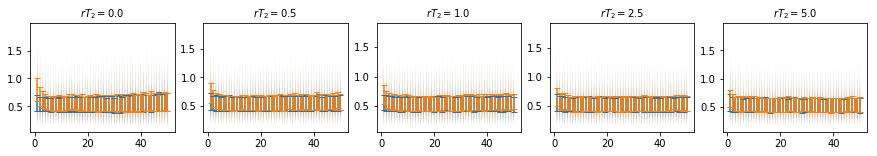

1.95


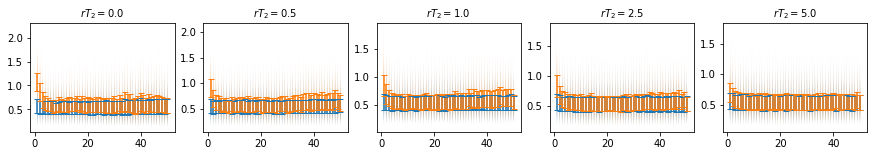

1.9


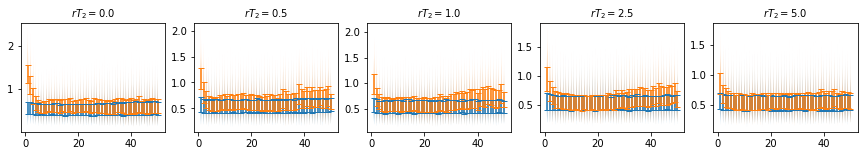

1.85


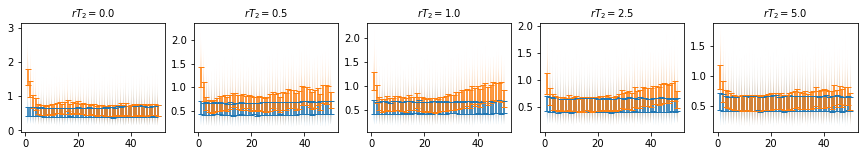

1.8


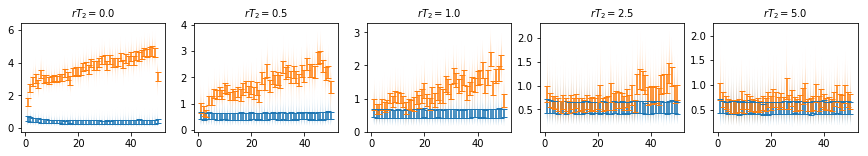

1.75


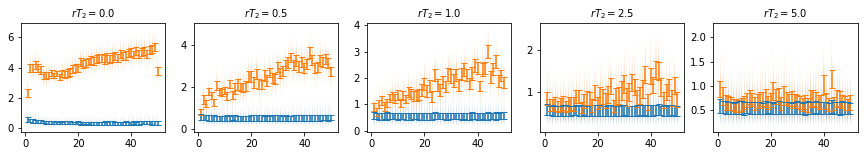

1.625


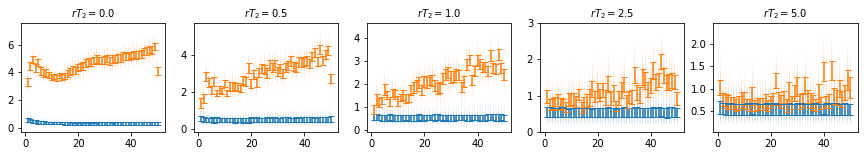

1.5


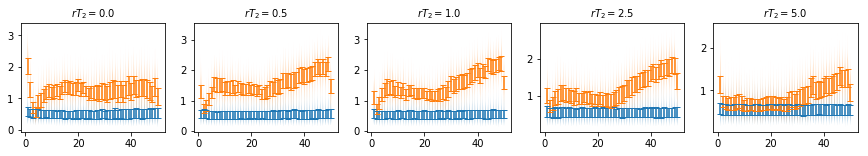

In [28]:
n_pairs = 10000
for alpha in ALPHAS:
    print(alpha)
    fig = plt.figure(figsize=(15,2))
    for i, r in enumerate(RS):
        ax = fig.add_subplot(1, len(RS), i+1)
        ax.set_title("$r T_2 = {}$".format(r))
        try:
            violin_with_iqrange(ax, D_kingman[(alpha,r,n_pairs)], 'C0')
            violin_with_iqrange(ax, D_xibeta[(alpha,r,n_pairs)], 'C1')
        except KeyError:
            continue
    plt.show()


1.975


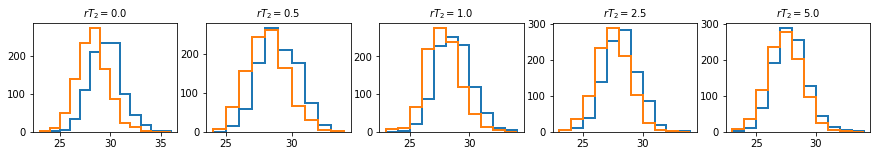

1.95


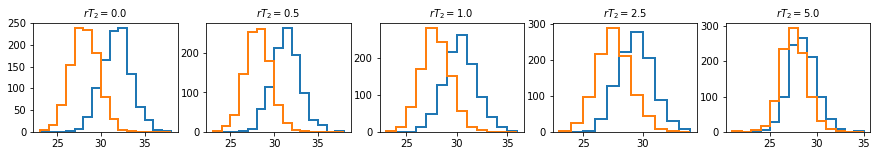

1.9


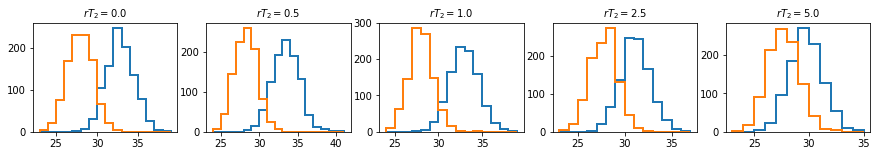

1.85


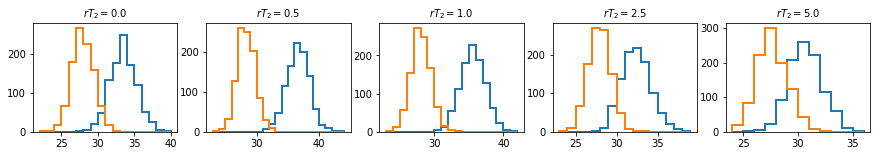

1.8


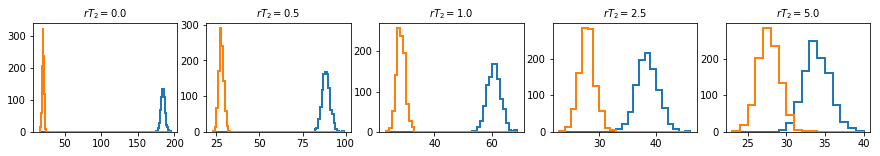

1.75


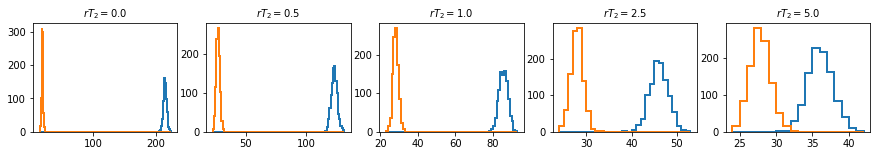

1.625


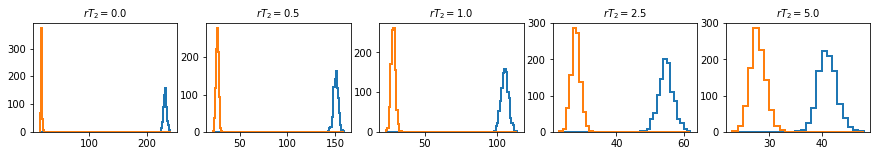

1.5


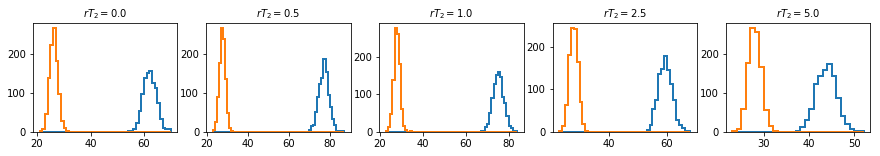

In [29]:
# bins=np.arange(0,400)
r = 1.0
n_pairs = 10000
for alpha in ALPHAS:
    print(alpha)
    fig = plt.figure(figsize=(15,2))
    for i, r in enumerate(RS):
        ax = fig.add_subplot(1, len(RS), i+1)
        ax.set_title("$r T_2 = {}$".format(r))
        try:
            d_xibeta = np.sum(D_xibeta[(alpha,r,n_pairs)], axis=1)
            d_fitted = np.sum(D_kingman[(alpha,r,n_pairs)], axis=1)
        except KeyError:
            continue
            
        lb = np.floor(np.min(np.hstack([d_fitted, d_xibeta])))
        ub = np.ceil(np.max(np.hstack([d_fitted, d_xibeta])))
        bins = np.arange(lb, ub+1, 1)
        plt.hist(d_xibeta, histtype='step', lw=2, bins=bins)
        plt.hist(d_fitted, histtype='step', lw=2, bins=bins)
#         plt.xlim([lb, ub])
    plt.show()

In [30]:
power = {}
for r in RS:
    for n_pairs in NPAIRS:
        power[(r, n_pairs)] = np.zeros(len(ALPHAS))
        for i, alpha in enumerate(ALPHAS):
            try:
                total_xibeta = np.sum(D_xibeta[(alpha, r, n_pairs)], axis=1)
                total_fitted = np.sum(D_kingman[(alpha, r, n_pairs)], axis=1)
            except KeyError:
                continue
#                 power[(r,n_pairs)][i] = np.nan
            power[(r,n_pairs)][i] = np.mean(rank(total_xibeta, total_fitted) > 0.95*n_resample)
            

/Users/danielrice/miniconda3/envs/multiplemergers/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


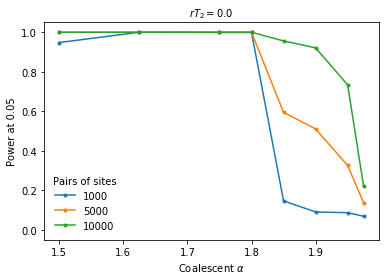

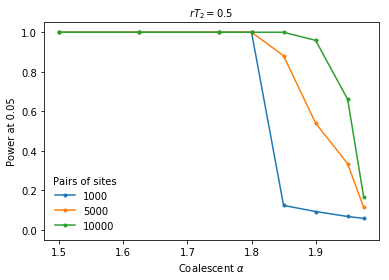

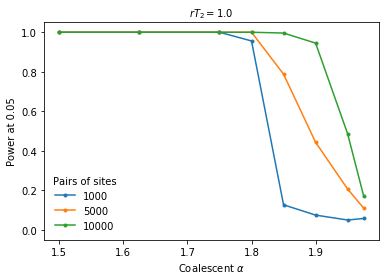

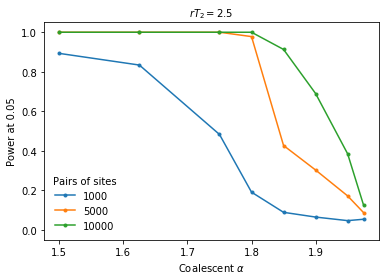

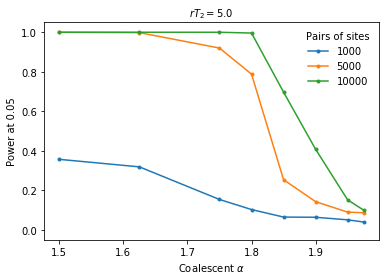

In [31]:
for r in RS:
    for n_pairs in NPAIRS:
        plt.plot(ALPHAS, power[(r,n_pairs)], '.-', label=n_pairs)    
    plt.ylim([-0.05,1.05])  
    plt.title("$r T_2 = {}$".format(r))
    plt.legend(title="Pairs of sites")
    plt.ylabel("Power at 0.05")
    plt.xlabel(r"Coalescent $\alpha$")
    plt.show()

## Repeat on lumped 2-SFS

In [32]:
n_resample = 1000
D_kingman = {}
D_xibeta = {}

for alpha in ALPHAS:
    for r in RS:
        try:
            f_xibeta = lump_2sfs(normalize_sfs(fold_twosfs(twosfs_xibeta[(alpha,r)])), maxb)
            f_fitted = lump_2sfs(normalize_sfs(fold_twosfs(twosfs_fitted[(alpha,r)])), maxb)
        except:
            continue
        F_xibeta = conditional_sfs(f_xibeta)
        F_fitted = conditional_sfs(f_fitted)
        
        for n_pairs in NPAIRS:
            D_kingman[(alpha,r, n_pairs)] = resample_distance(f_fitted, f_fitted, n_pairs, n_resample)
            D_xibeta[(alpha,r, n_pairs)] = resample_distance(f_xibeta, f_fitted, n_pairs, n_resample)

1.975


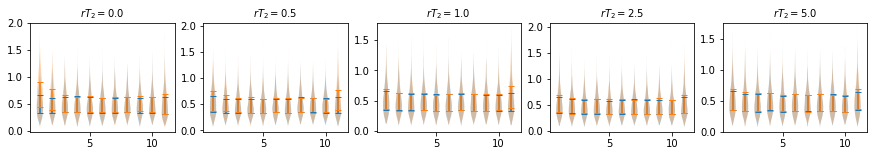

1.95


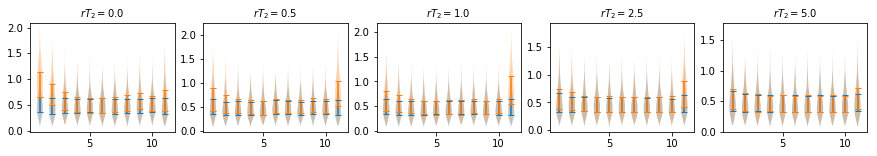

1.9


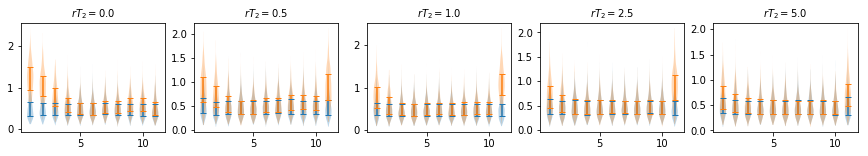

1.85


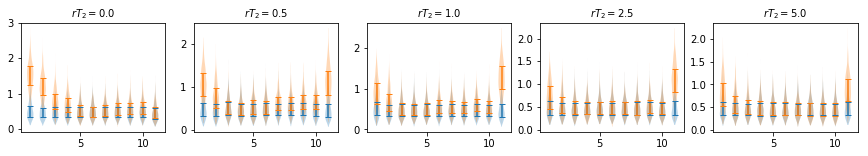

1.8


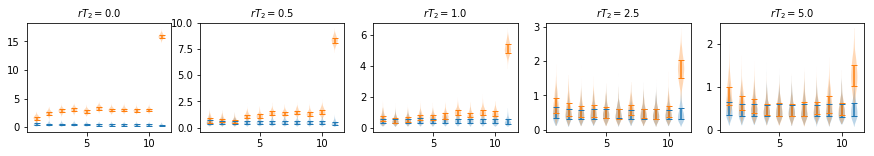

1.75


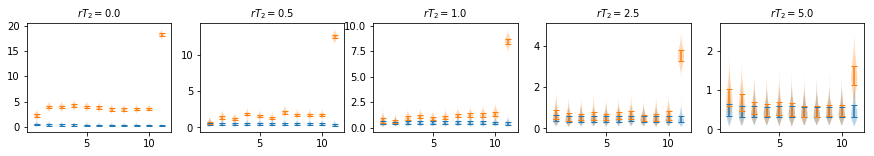

1.625


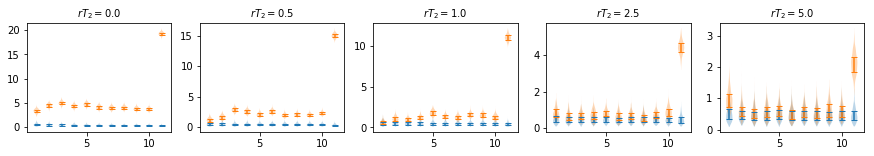

1.5


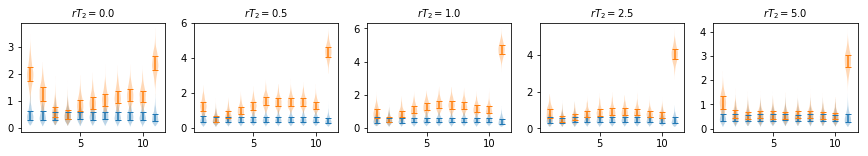

In [33]:
n_pairs = 10000
for alpha in ALPHAS:
    print(alpha)
    fig = plt.figure(figsize=(15,2))
    for i, r in enumerate(RS):
        ax = fig.add_subplot(1, len(RS), i+1)
        ax.set_title("$r T_2 = {}$".format(r))
        try:
            violin_with_iqrange(ax, D_kingman[(alpha,r,n_pairs)], 'C0')
            violin_with_iqrange(ax, D_xibeta[(alpha,r,n_pairs)], 'C1')
        except KeyError:
            continue
    plt.show()


1.975


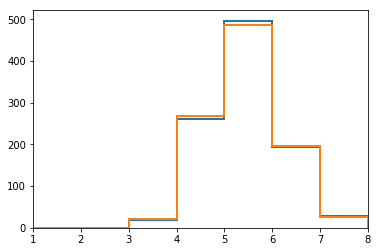

1.95


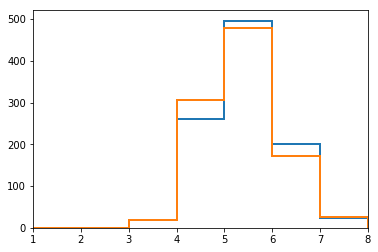

1.9


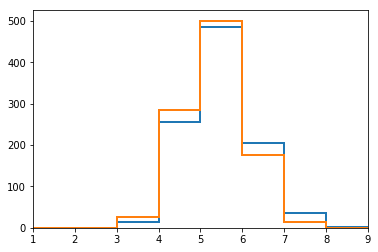

1.85


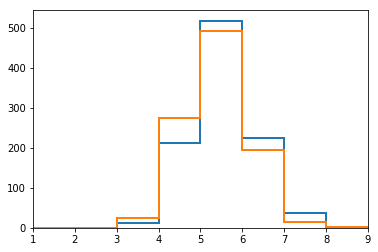

1.8


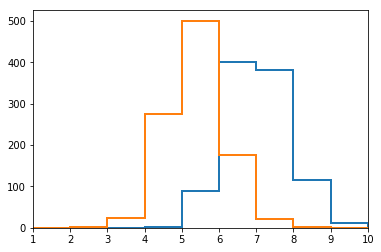

1.75


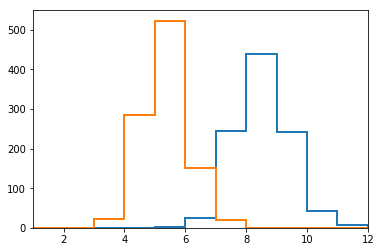

1.625


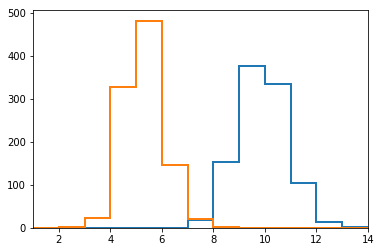

1.5


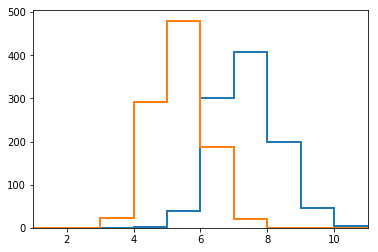

In [34]:
bins=np.arange(1,100)
r = 1.0
n_pairs = 1000
for alpha in ALPHAS:
    print(alpha)
    try:
        plt.hist(np.sum(D_xibeta[(alpha,r,n_pairs)], axis=1), histtype='step', lw=2, bins=bins)
        plt.hist(np.sum(D_kingman[(alpha,r,n_pairs)], axis=1), histtype='step', lw=2, bins=bins)
    except KeyError:
        continue
    plt.xlim([1, np.ceil(np.max(np.sum(D_xibeta[(alpha,r,n_pairs)], axis=1)))])
    plt.show()

In [35]:
power = {}
for r in RS:
    for n_pairs in NPAIRS:
        power[(r, n_pairs)] = np.zeros(len(ALPHAS))
        for i, alpha in enumerate(ALPHAS):
            try:
                total_xibeta = np.sum(D_xibeta[(alpha, r, n_pairs)], axis=1)
                total_fitted = np.sum(D_kingman[(alpha, r, n_pairs)], axis=1)
            except KeyError:
                continue
            power[(r,n_pairs)][i] = np.mean(rank(total_xibeta, total_fitted) > 0.95*n_resample)
            

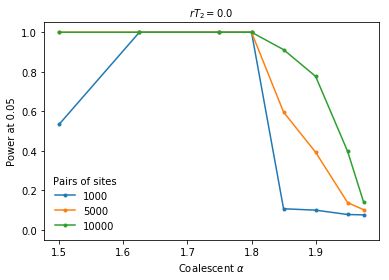

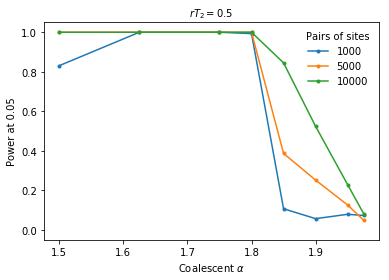

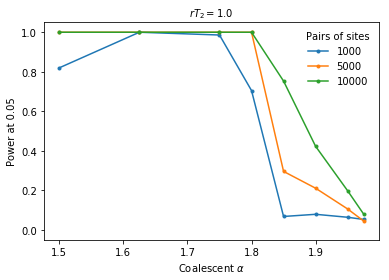

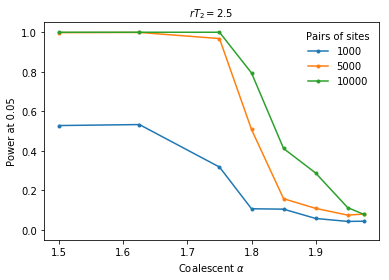

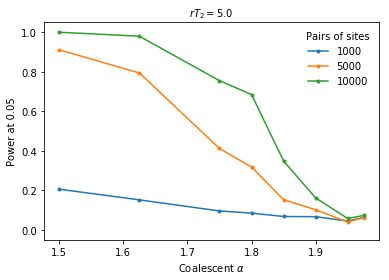

In [36]:
for r in RS:
    for n_pairs in NPAIRS:
        try:
            plt.plot(ALPHAS, power[(r,n_pairs)], '.-', label=n_pairs)    
        except KeyError:
            continue
    plt.ylim([-0.05,1.05])  
    plt.title("$r T_2 = {}$".format(r))
    plt.legend(title="Pairs of sites")
    plt.ylabel("Power at 0.05")
    plt.xlabel(r"Coalescent $\alpha$")
    plt.show()